# Imports

In [2]:
import numpy as np
import os
%load_ext autoreload
%autoreload 2
import sys
import os


# Get the current folder path and go up one level ('..') to the project root
project_root = os.path.abspath('..')

# Add the root to the system path so Python can find 'src'
if project_root not in sys.path:
    sys.path.append(project_root)
%load_ext autoreload
%autoreload 2
from keras.src.metrics import Precision
from keras.src.metrics.metrics_utils import confusion_matrix

np.random.seed(42) #to make results reproducible

# Matplotlib and seaborn configuration
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Function to save Figures

In [3]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Importing Dataset

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
print(mnist["frame"])
print(mnist["feature_names"]) #28 x 28 = 784 Pixels
print(mnist["target_names"]) # Class

None
['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 'pixel69', 'pixel70', 'pixel71', 'pixel72', 'pixel73', 'pixel74', 'pixel75', 'pixel76', 'pixel77', 'pixel78', 'pixel79', 'pixel80', 'pixel81', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel86', 'pixel87', 'pixel88', 'pixel89', 'pixel90', 'pixel91', 'p

In [6]:
print(mnist["categories"])

{'class': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}


In [7]:
print("description", mnist["DESCR"])
print("details", mnist["details"])
print("categories", mnist["categories"])
print("url", mnist["url"])

description **Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 2

In [8]:
X , y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [9]:
y.shape

(70000,)

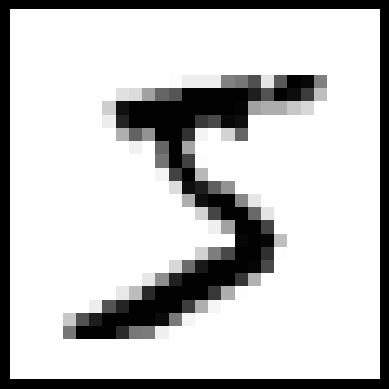

Saving figure some_digit_plot


<Figure size 640x480 with 0 Axes>

In [10]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis('off')
plt.show()
save_fig("some_digit_plot")

In [11]:
y[0]

'5'

In [12]:
y = y.astype(np.uint8)

In [13]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [14]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis = 0)
    plt.imshow(image, cmap = mpl.cm.binary , **options)
    plt.axis("off")

Saving figure more_digits_plot


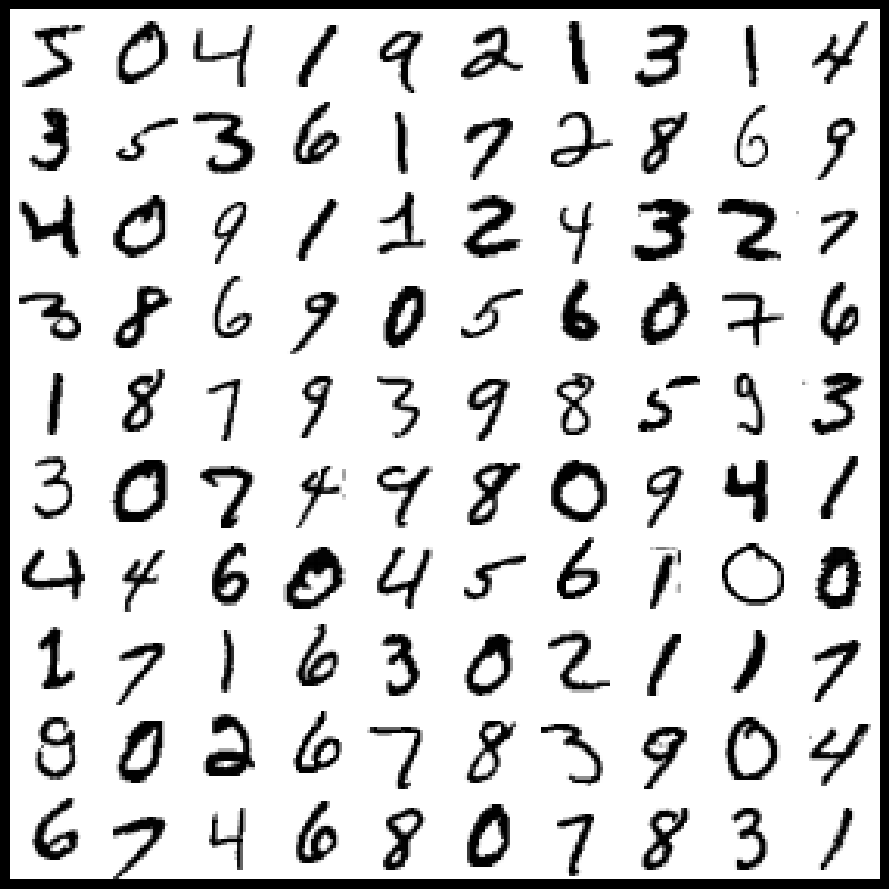

In [15]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [16]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary Classifier

In [17]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5 )

In [18]:
from sklearn.linear_model import SGDClassifier
#Stochastic Gradient Descent (SGD)
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [19]:
sgd_clf.predict([some_digit])

array([ True])

In [20]:
from sklearn.model_selection import cross_val_score, cross_val_predict

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [21]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


False = no 5s detected

In [22]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3 , scoring="accuracy" )

array([0.90965, 0.90965, 0.90965])

It has 90 Percent accuracy; ONLY COZ IT HAS 10 PERCENT OF IMAGES are 5s.
this is why accuracy is not a preffered performance measure for classifiers.
especillay when dataset is screwed or much classes are more frequent than others.for this we use



In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) # add shuffle = True if the dataset is not shuffled
for train_index, test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.95035
0.96035
0.9604


# Confusion Matrices
it is to count the no. of items  its getting confused class A with other Classes B.
1. to compute first we need predictions and actual values.
2.but dont use test set , we use cross_val_product


In [24]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5 , cv=3)

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

True Negative (TN): The model correctly ignored the non-5 images (53,892 times).

False Positive (Type I): The model made a "False Alarm." It thought a non-5 was a 5 (687 times).

False Negative (Type II): The model "Missed" the target. It failed to see a real 5 (1,891 times).

True Positive (TP): The model correctly spotted the 5s (3,530 times).

In [26]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

confusion matrix gives us a lot of info sometimes we want less , and more concise , that time we gonna use Precision Classifier

# Precision and Recall


In [27]:
from sklearn.metrics import  precision_score, recall_score

precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [28]:
#computes the precision: TP / (FP + TP)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

np.float64(0.8370879772350012)

In [29]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

In [30]:
#computes the recall: TP / (FN + TP)
cm[1, 1] / (cm[1, 0] + cm[1, 1])

np.float64(0.6511713705958311)

to combine it into a single metric , we combine precision and recall score to become F1 score.

In [31]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [32]:
#computes the f1 score
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

np.float64(0.7325171197343847)

In [33]:
# 1. Look at the confusion matrix
print(confusion_matrix(y_train_5, y_train_pred))

# 2. Check Precision, Recall, and F1 Score
print("Precision:", precision_score(y_train_5, y_train_pred)) #When it claims an image is a 5, how often is it actually correct?
print("Recall:", recall_score(y_train_5, y_train_pred))# Out of all the actual 5s in the dataset, what percentage did the model successfully find?
print("F1 Score:", f1_score(y_train_5, y_train_pred))
#A combination of Precision and Recall into a single number


[[53892   687]
 [ 1891  3530]]
Precision: 0.8370879772350012
Recall: 0.6511713705958311
F1 Score: 0.7325171197343847


# Precision/Recall Trade-off

In [34]:
y_scores = sgd_clf.decision_function([some_digit])
#instead of predict function we can use decision_function which allows u to make the prediction based on the threshold value u assign
y_scores
threshold = 0 #inital threshold which gives same value as predict

In [35]:
y_some_digit_pred = (y_scores > threshold)

In [36]:
#increasing threshold
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

increasing threshold decreases the RECALL , when we predicted with 0 threshold it actually predicted that its 5 but when we shifted to 3000 it changed it to False. hence the threshold works

now which one to use , **first** use the Cross val predict , but with decision_function instead of predict method.


In [37]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method= "decision_function")

**Second** use the precision_recall_curve to compute precision and recall for all the possible thresholds

In [38]:
from sklearn.metrics import  precision_recall_curve
precisions , recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [39]:
print(type(precisions))
print(len(precisions))
print(precisions.shape)
print(precisions[0:5])

<class 'numpy.ndarray'>
60001
(60001,)
[0.09035    0.09035151 0.09035301 0.09035452 0.09035602]


Saving figure precision_recall_curve


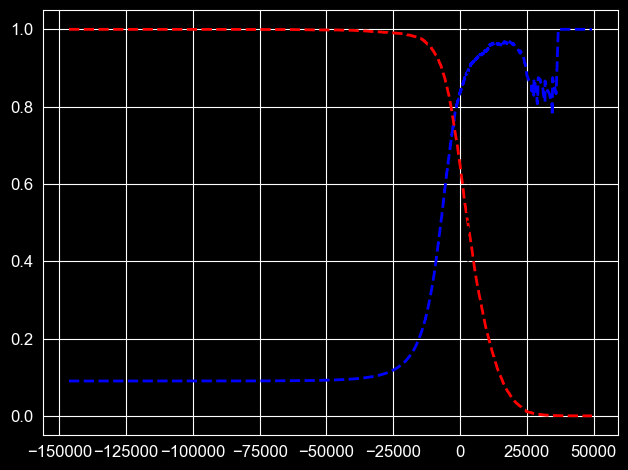

In [40]:
plt.plot(thresholds, precisions[:-1], "b--", label = "Precision", linewidth = 2)
plt.plot(thresholds, recalls[:-1], "r--", label = "Recall", linewidth = 2)
plt.vlines(threshold, 0 , 1.0, "k", "dotted" , label = "threshold")
save_fig("precision_recall_curve")
plt.show()

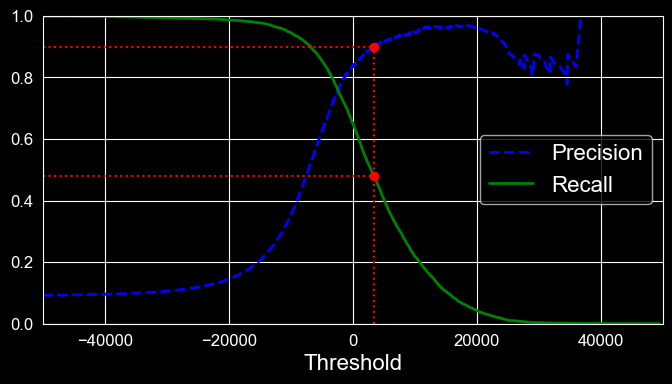

In [41]:
#importing from different files
from src.extras import plot_precision_recall_vs_threshold

plot_precision_recall_vs_threshold(precisions, recalls, thresholds, target_precision=0.90, save_name="precision_recall_vs_threshold_plot")